# Import libraries

In [1]:
#%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

## Setting max displayed rows to 500, in order to display the full output of any command
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Setting to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# pour que les valeurs infinies soient considérées aussi comme des NaN :
pd.options.mode.use_inf_as_na = True



import sqlalchemy


# sklearn
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# pipelines
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
# preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
# feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
# models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
# model selection
from sklearn.model_selection import RandomizedSearchCV
# scores
from sklearn.model_selection import cross_val_predict, cross_val_score

# Préparation du dataset

In [3]:
import datetime
def calcul_ratios(df):
    df["Credit client"] = (df['Clients et comptes rattachés (3) (net) (BXNET) 2018 (€)']*365)/(df["Chiffre d'affaires net (Total) (FL) 2018 (€)"]*1.2)

    df["Credit Fournisseurs"] = df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']*365/(
        (df['Achats de marchandises (y compris droits de douane) (FS) 2018 (€)'] 
        + df['Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2018 (€)'] 
        + df['Autres achats et charges externes (3) (6 bis) (FW) 2018 (€)']
        )*1.2)

    df["Rotation_stocks"] = ( df['Matières premières, approvisionnements (net) (BLNET) 2018 (€)'] + 
             + df['En cours de production de biens (net) (BNNET) 2018 (€)'] 
             + df['En cours de production de services (net) (BPNET) 2018 (€)']
             + df['Produits intermédiaires et finis (net) (BRNET) 2018 (€)']
             + df['Marchandises (net) (BTNET) 2018 (€)'])*365 / (
                df["Chiffre d'affaires net (Total) (FL) 2018 (€)"]  
                - df["1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2018 (€)"])

    df["BFR"] = (
        df['TOTAL (III) (net) (CJNET) 2018 (€)']
        + df['Valeurs mobilières de placement (net) (CDNET) 2018 (€)']
        + df['Disponibilités (net) (CFNET) 2018 (€)']
        - df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
        - df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
        - df['Dettes fiscales et sociales (DY) 2018 (€)']
        - df['Dettes sur immobilisations et comptes rattachés (DZ) 2018 (€)']
        - df['Autres dettes (EA) 2018 (€)']
        - df["Produits constatés d'avance (EB) 2018 (€)"])


    df["BFRE"] = (
                df['Matières premières, approvisionnements (net) (BLNET) 2018 (€)']
                 + df['En cours de production de services (net) (BPNET) 2018 (€)']
                 + df['En cours de production de biens (net) (BNNET) 2018 (€)']
                 + df['Produits intermédiaires et finis (net) (BRNET) 2018 (€)']
                 + df['Marchandises (net) (BTNET) 2018 (€)']
                 + df['Avances et acomptes versés sur commandes (net) (BVNET) 2018 (€)']
                 + df['Clients et comptes rattachés (3) (net) (BXNET) 2018 (€)']
                - df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
                - df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
                - df['Dettes fiscales et sociales (DY) 2018 (€)']
                - df['Autres dettes (EA) 2018 (€)']
                 )

    df["Endettement total"] = (df['Autres emprunts obligataires (DT) 2018 (€)']
                 + df['Emprunts obligataires convertibles (DS) 2018 (€)']
                 + df['Emprunts et dettes auprès des établissements de crédit (5) (DU) 2018 (€)']
                 + df['Emprunts et dettes financières divers (DV) 2018 (€)']
                - df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)'])

    df["CAF"] = (df['3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2018 (€)']
                - df['Reprises sur amortissements et provisions, transferts de charges (9) (FP) 2018 (€)']
                + df["Dotations d'exploitation sur immobilisations (dotations aux amortissements) (GA) 2018 (€)"]
                + df["Dotations d'exploitation sur immobilisations (dotations aux provisions) (GB) 2018 (€)"]
                + df["Dotations d'exploitation sur actif circulant (dotations aux provisions) (GC) 2018 (€)"]
                + df["Dotations d'exploitation pour risques et charges (dotations aux provisions) (GD) 2018 (€)"]
                - df['Reprises sur provisions & transferts de charges (GM) 2018 (€)']
                + df['Dotations financières aux amortissements et provisions (GQ) 2018 (€)']
                - df["Participation des salariés aux résultats de l'entreprise (HJ) 2018 (€)"]
                - df['Impôts sur les bénéfices (HK) 2018 (€)'])

    df["Capacite de remboursement"] = df["Endettement total"] / df["CAF"]


    df["Ressources durables"] = (df['TOTAL (I) (DL) 2018 (€)']
                 + df['TOTAL(II) (DO) 2018 (€)']
                 + df['TOTAL (III) (DR) 2018 (€)']
                 + df['Autres emprunts obligataires (DT) 2018 (€)']
                 + df['Emprunts obligataires convertibles (DS) 2018 (€)']
                 + df['Emprunts et dettes auprès des établissements de crédit (5) (DU) 2018 (€)']
                 + df['Emprunts et dettes financières divers (DV) 2018 (€)']
                 - df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)']
                 - df['Capital souscrit non appelé (I) (AA) 2018 (€)'])


    df["FRNG"] = (df["Ressources durables"]   
                 + df['Ecarts de conversion passif (V) (ED) 2018 (€)']
                 - df['Primes de remboursement des obligations (CM) 2018 (€)']
                 - df['Ecarts de conversion actif (CN) 2018 (€)']
                 + df['TOTAL (II) (net) (BJNET) 2018 (€)'])

    df["Taux endettement"] = df["Endettement total"] / df["Ressources durables"]

    df["Rentabilite financiere"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)"] 
                                    / (df['TOTAL (I) (DL) 2018 (€)'] 
                                       - df['Capital souscrit non appelé (I) (AA) 2018 (€)']))

    df["EBE"] = (df["Chiffre d'affaires net (Total) (FL) 2018 (€)"]
                + df["Subventions d'exploitation (FO) 2018 (€)"]
                + df['Production stockée (FM) 2018 (€)']
                + df['Production immobilisée (FN) 2018 (€)']
                - df['Achats de marchandises (y compris droits de douane) (FS) 2018 (€)']
                - df['Variation de stock (marchandises) (FT) 2018 (€)']
                - df['Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2018 (€)']
                - df['Variation de stock (matières premières et approvisionnements) (FV) 2018 (€)']
                - df['Autres achats et charges externes (3) (6 bis) (FW) 2018 (€)']
                - df['Impôts, taxes et versements assimilés (FX) 2018 (€)']
                - df['Salaires et traitements (FY) 2018 (€)']
                - df['Charges sociales (10) (FZ) 2018 (€)']
                + df['(3)\xa0Dont Crédit-bail mobilier (HP) 2018 (€)']
                + df['(3)\xa0Dont Crédit-bail immobilier (HQ) 2018 (€)']
                )

    df["VA"] = (df["EBE"] 
                - df["Subventions d'exploitation (FO) 2018 (€)"]
                + df['Impôts, taxes et versements assimilés (FX) 2018 (€)']
                + df['Salaires et traitements (FY) 2018 (€)']
                + df['Charges sociales (10) (FZ) 2018 (€)'])

    df["Liquidite generale"] = ((df['TOTAL (III) (net) (CJNET) 2018 (€)']
                               - df["Charges constatées d'avance (3) (net) (CHNET) 2018 (€)"])
                               / (df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
                                 + df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
                                 + df['Dettes fiscales et sociales (DY) 2018 (€)']
                                 + df['Dettes sur immobilisations et comptes rattachés (DZ) 2018 (€)']
                                 + df['Autres dettes (EA) 2018 (€)']
                                 + df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)']))


    df["Liquidite reduite"] = (
        (
            (df['TOTAL (III) (net) (CJNET) 2018 (€)']
                               - df["Charges constatées d'avance (3) (net) (CHNET) 2018 (€)"]
            )
                               - (
                                   df['Matières premières, approvisionnements (net) (BLNET) 2018 (€)']
                                 + df['En cours de production de services (net) (BPNET) 2018 (€)']
                                 + df['En cours de production de biens (net) (BNNET) 2018 (€)']
                                 + df['Produits intermédiaires et finis (net) (BRNET) 2018 (€)']
                                 + df['Marchandises (net) (BTNET) 2018 (€)']
                                 )
        ) 
                                / (
                                    df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
                                 + df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
                                 + df['Dettes fiscales et sociales (DY) 2018 (€)']
                                 + df['Dettes sur immobilisations et comptes rattachés (DZ) 2018 (€)']
                                 + df['Autres dettes (EA) 2018 (€)']
                                 + df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)']
                                    )
                                )

    df["Taux ressources propres"] = ((df['TOTAL (I) (DL) 2018 (€)'] 
                                     - df['Capital souscrit non appelé (I) (AA) 2018 (€)'])
                                    / df['TOTAL GENERAL (I à V) (EE) 2018 (€)'])

    #df["CA par employe"] = gérer les 0

    df["Rentabilite des capitaux propres"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)"]
                                             / (df['TOTAL (I) (DL) 2018 (€)']
                                                + df['TOTAL(II) (DO) 2018 (€)']
                                                - df['Capital souscrit non appelé (I) (AA) 2018 (€)']))

    df["Autonomie financiere"] = ((df['TOTAL (I) (DL) 2018 (€)']
                                                + df['TOTAL(II) (DO) 2018 (€)']
                                                - df['Capital souscrit non appelé (I) (AA) 2018 (€)'])
                                  / df['TOTAL GENERAL (I à V) (EE) 2018 (€)'])

    df["Poids interets"] = (df['Intérêts et charges assimilées (GR) 2018 (€)'] 
                            / df["1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2018 (€)"])

    df["Taux EBE"] = (df["EBE"]
                      / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])

    df["Taux VA"] = (df["VA"]
                      / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])

    df["Taux Rentabilite"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)"]
                             / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])

    df["Poids dettes fiscales"] = ((df['Sécurité sociale et autres organismes sociaux - Montant brut (8D) 2018 (€)']
                                   + df['Impôts sur les bénéfices - Montant brut (8E) 2018 (€)']
                                   + df['T.V.A. - Montant brut (VW) 2018 (€)'])
                                   / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])


    df["Tresorerie"] = df["FRNG"] - df["BFR"]
    
    df["Taux augmentation endettement CT"] = (df['Emprunts souscrits en cours d’exercice - à 1 an au plus (VJ2) 2018 (€)']
                                         / df['TOTAL GENERAL (I à V) (EE) 2018 (€)'])

    
    df["Croissance CA"] = ((df["Chiffre d'affaires net (Total) (FL) 2018 (€)"] 
                       - df["Chiffre d'affaires net (Total) (FL) 2017 (€)"]) 
                        / df["Chiffre d'affaires net (Total) (FL) 2017 (€)"]) 
    
    df["Apport en comptes courants"] = (df["dont comptes courants d'associés de l'exercice N (EA2) 2018 (€)"] 
                       - df["dont comptes courants d'associés de l'exercice N (EA2) 2017 (€)"]) 
                      
    df["Date de création"] = pd.to_datetime(df["Date de création"])
    df["Age entreprise"] = ((datetime.datetime(2019,12,31) - df["Date de création"])/np.timedelta64(1, 'M'))
    df["Age entreprise"] = df["Age entreprise"].astype(int)
    
    return df

In [4]:
def suppr_nulls_nans(df):
    # suppression des entreprises avec CA null
    df = df[df["Chiffre d'affaires net (Total) (FL) 2018 (€)"] > 0]
    # suppression des colonnes avec plus de 12% de NaN (sauf tranche d'effectif)
    cols_null_to_drop = ["Procédures collectives (type)", 
                         "Procédures collectives (date)", 
                         "Croissance CA", 
                         "Apport en comptes courants", 
                         "dont comptes courants d'associés de l'exercice N (EA2) 2017 (€)", 
                         "Chiffre d'affaires net (Total) (FL) 2017 (€)"]
    df = df.drop(cols_null_to_drop, axis=1)
    # passage des valeurs infinies en nan
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [5]:
def merge_naf(df, naf_path):
    df_naf = pd.read_excel(naf_path, header=[1])
    df_naf = df_naf.drop(["Unnamed: 10", "Unnamed: 11", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15",
            "Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", "Unnamed: 21", "Unnamed: 22"], axis=1)
    df_naf = df_naf.rename(columns={'Unnamed: 1':'Descriptif A 732'})
    # Step 1 - suppression des points dans la colonne A 732
    # pour avoir le même format que dans les données d'entreprises
    for row in range(df_naf.shape[0]):
        df_naf.loc[row,'A 732'] = df_naf.loc[row,'A 732'].replace('.', '')
    # Step 2 - Join avec le dataset d'entreprises 
    # (pour la mise en DB, il faudra créér deux tables et faire les joins dans la requête SQL)
    df_merged = pd.merge(df, df_naf, how = 'left', left_on = df['Code APE'], right_on = df_naf['A 732'])
    df_merged = df_merged.drop(['key_0'], axis=1)
    assert df_merged.shape[0]==df.shape[0]
    assert df_merged.shape[1]==df.shape[1]+df_naf.shape[1]
    return df_merged, df_naf

In [6]:
# no longer used
def effectif_encoder(df):
    dic_effectif = { "0 salarié pendant l'année" : 0
                , "0 salarié à la fin de l'année" : 1
                , "De 1 à 2 salariés" : 2
                , "De 3 à 5 salariés" : 3
                , "De 6 à 9 salariés" : 4
                , "De 10 à 19 salariés" : 5
                , "De 20 à 49 salariés" : 6
                , "De 50 à 99 salariés" : 7
                , "De 100 à 199 salariés" : 8
                , "De 200 à 249 salariés" : 9
                , "De 250 à 499 salariés" : 10
                , "De 500 à 999 salariés" : 11
                , "De 1000 à 1999 salariés" : 12
                , "De 2000 à 4999 salariés" : 13 
    }
    df["Tranche effectifs"] = df["Tranche effectifs"].map(dic_effectif)
    return df

In [7]:
# no longer used
def encode_naf21(df):
    dict_naf21 = {'C':0,
                  'E':1,
                  'P':2,
                  'H':3,
                  'F':4,
                  'I':5,
                  'R':6,
                  'G':7,
                  'N':8,
                  'J':9,
                  'S':10,
                  'Q':11,
                  'M':12,
                  'K':13,
                  'A':14,
                  'L':15,
                  'D':16,
                  'O':17,
                  'B':18
    }
    df["A 21 encoded"] = df["A 21"].map(dict_naf21)
    return df

In [8]:
def remove_useless_cols(df):
    useless_cols = [
        "Dénomination",
        "Tranche effectifs",
        "Code APE",
        "Ville",
        "Emprunts remboursés en cours d’exercice (VK) 2018 (€)",
        "Descriptif A 732",
        "A 732",
        "A 615",
        "A 272",
        "A 129",
        "A 88",
        "A 64",
        "A 38",
        "A 10",
        "SIREN",
        "SIRET",
        "Code postal",
        "Emprunts souscrits en cours d’exercice - à 1 an au plus (VJ2) 2018 (€)",
        "Emprunts souscrits en cours d’exercice - à plus d'un an et 5 ans au plus (VJ3) 2018 (€)",
        "Emprunts souscrits en cours d’exercice - à plus de 5 ans (VJ4) 2018 (€)"
    ]
    
    df = df.drop(useless_cols, axis=1)
    return df

In [9]:
def count_outliers(df, col):
    mean = np.mean(df[col], axis=0)
    sd = np.std(df[col], axis=0)
    minimum = mean - 20 * sd
    maximum = mean + 20 * sd
    df_outliers = df.loc[(df[col] <= minimum) | (df[col] >= maximum)]
    return df_outliers.shape[0]

def remove_outliers(df, col):
    mean = np.mean(df[col], axis=0)
    sd = np.std(df[col], axis=0)
    minimum = mean - 20 * sd
    maximum = mean + 20 * sd
    df = df.loc[(df[col] > minimum) & (df[col] < maximum)]
    return df

In [10]:
def apply_categorical_dtypes(df):
    df = df.astype({"Catégorie juridique (Niveau II)" : 'category', 
                            'A 21' : 'category'})
    return df

In [11]:
def get_prepared_df():
    df = pd.read_csv("../data/data_used/total_2018.csv", sep=",")
    df = calcul_ratios(df)
    df = suppr_nulls_nans(df)
    df, df_naf = merge_naf(df, naf_path="../data/data_used/table_NAF2-NA.xls")
    df = remove_useless_cols(df)
    df = apply_categorical_dtypes(df)
    for col in df.select_dtypes(np.number):
        df = remove_outliers(df, col)
    return df

In [12]:
df = get_prepared_df()
df.shape

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(5740, 116)

## Fonction d'évaluation des modèles

In [13]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
# la learning curve est indispensable pour identifier l'over ou l'under fitting
# inspirée de machine_lerania
from sklearn.model_selection import learning_curve

def evaluate(model, X_train, y_train, X_test, y_test):
    
    # on entraine le modèle
    model.fit(X_train, y_train)
    # on fait les predictions
    y_pred = model.predict(X_test)
    
    # on fait la confusion_matrix
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
    conf = conf.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
    conf = conf.rename(index={0: 'Actual 0',1:"Actual 1"})
    conf["TOTAL"] = conf["Predicted 0"]+conf["Predicted 1"]
    conf = conf.append(pd.Series(conf.sum(axis=0), name="TOTAL"))

    
    print("__---__ CONFUSION MATRIX __---__")
    print(conf)
    print("\n__---__ CLASSIFICATION REPORT __---__")
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    # on visualise ca dans un graphique
    plt.figure(figsize=(12, 8))
    # évolu du train_score en fonction du nombre d'échantillons (N)
    # on prend le score_mean car on est en cross-val
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

# Exemple d'usage :    
#X1_train = trainset[["A 21 encoded"]]
#y1_train = trainset["default"]
#X1_test = testset[["A 21 encoded"]]
#y1_test = testset["default"]
# model = LogisticRegression()

#evaluate(model)    

In [13]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
# la learning curve est indispensable pour identifier l'over ou l'under fitting
# inspirée de machine_lerania
from sklearn.model_selection import learning_curve

def evaluate2(model, X_train, y_train, X_test, y_test):
    
    # on entraine le modèle
    model.fit(X_train, y_train)
    # on fait les predictions
    y_pred = model.predict(X_test)
    
    # on fait la confusion_matrix
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
    conf = conf.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
    conf = conf.rename(index={0: 'Actual 0',1:"Actual 1"})
    conf["TOTAL"] = conf["Predicted 0"]+conf["Predicted 1"]
    conf = conf.append(pd.Series(conf.sum(axis=0), name="TOTAL"))

    
    print("__---__ CONFUSION MATRIX __---__")
    print(conf)
    print("\n__---__ CLASSIFICATION REPORT __---__")
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    # on visualise ca dans un graphique
    plt.figure(figsize=(12, 8))
    # évolu du train_score en fonction du nombre d'échantillons (N)
    # on prend le score_mean car on est en cross-val
    plt.plot(N, (1-train_score.mean(axis=1)), label='train error')
    plt.plot(N, (1-val_score.mean(axis=1)), label='validation error')
    plt.legend()
    # Add title and axis names
    plt.title('LEARNING CURVES')
    plt.xlabel('sample size')
    plt.ylabel('error (1 - F1 score)')

# Exemple d'usage :    
#X1_train = trainset[["A 21 encoded"]]
#y1_train = trainset["default"]
#X1_test = testset[["A 21 encoded"]]
#y1_test = testset["default"]
# model = LogisticRegression()

#evaluate(model)   

# Baseline



# Premières amélioratons - tâtonnements 
## résumé
La régression logistique est conseillée pour commencer car c'est le plus simple.
Néanmoins on a beaucoup de variables :
- trop grande complexité => on n'arrive pas à converger, même en augmentant le max_iter, en jouant sur les solvers, et en jouant sur le nombre de paramètres via la régularisation
- trop de features : on sait qu'on a de la multicolinéarité, il faut régulariser. Même en jouant dessus, ça n'est pas top et ça ne converge pas.

-**MODELE 1 - BASELINE (régression logistique)**:
    - Utilisation des hyperparamètres classiques, seulement augmentation de max_iter=1000
    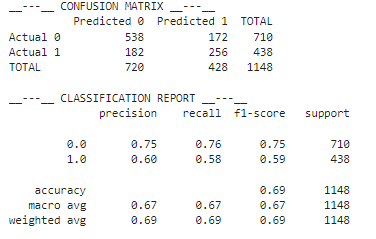
    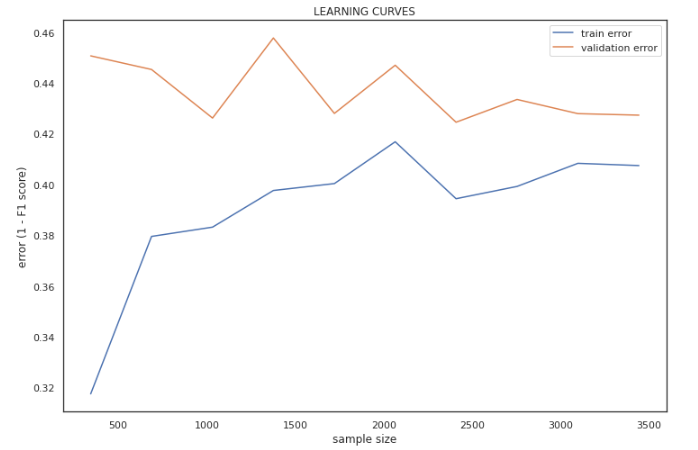

-**MODELE 2 - REGULARISATION**:
     - Utilisation d'un autre solver qui permet d'utiliser l1 (liblinear), et réduction de C à 0,5 ce qui accroit la pénalité et donc la régularisation
     - Ca semble être la bonne voie : les performances sont nettement améliorée, l'overfitting reste OK :
     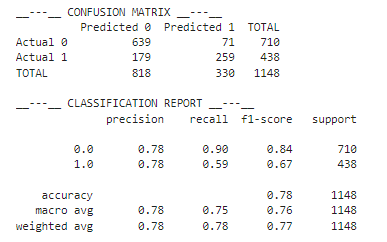
     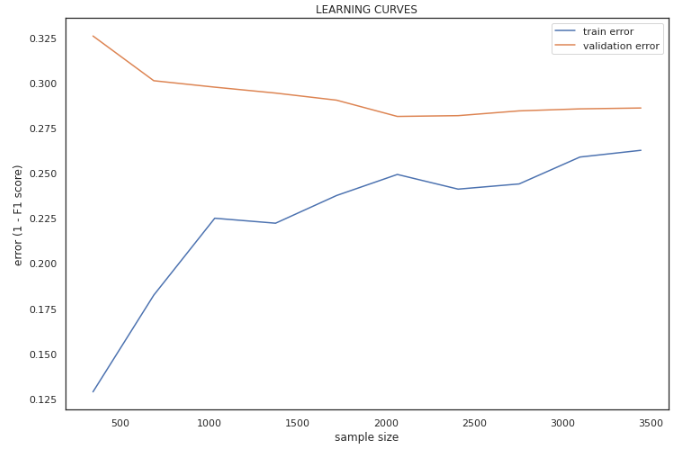



-**MODELE 3 - RANDOM FOREST**:
   - Comme on s'y attendait, on est dans le cadre d'un overfitting très important.
   - Mais on a quand même des résultats intéressants avec un f1 score de 0,76 !!
   - Il faut donc continuer dans cette voie, en cherchant à réduire le nombre de features pour diminuer l'overfitting => PCA ? VIF ?


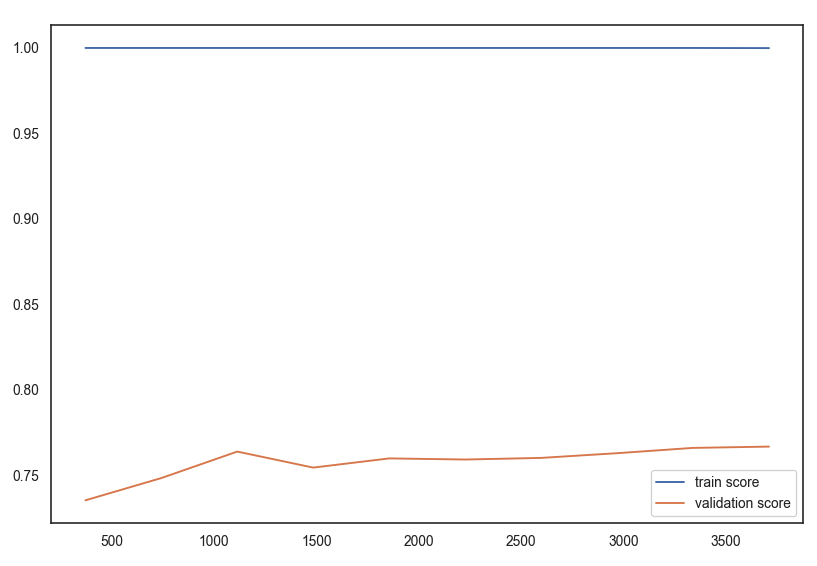
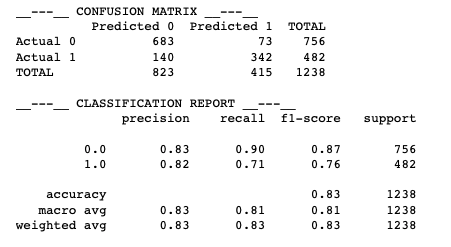


- Première étape : regardons la **feature importance.** Les plus importants sont 2 ratios financiers, puis 2 grands montants (bénéfice ou perte / total 1 DL - voir ce que c'est)
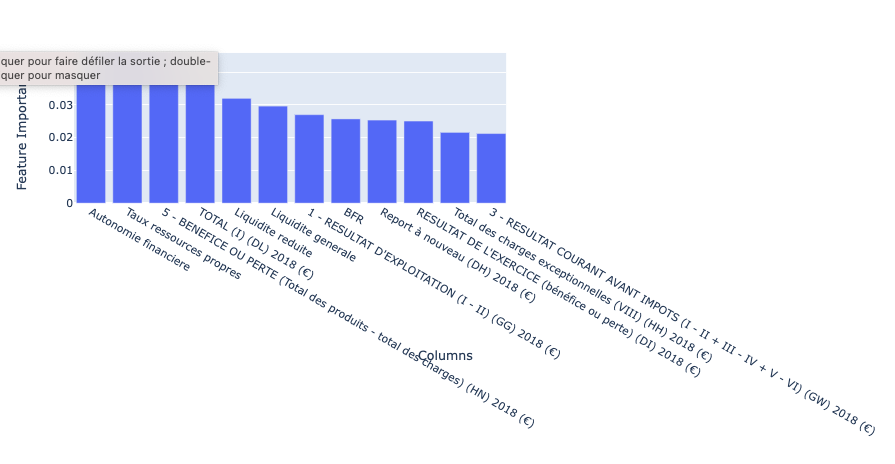



## Baseline
**On prend la df après suppression des outliers et des colonnes certainement inutiles**
On prend la df sans suppression des outliers (l'idée est que la plupart des outliers sont souvent des défaillantes, et que donc ils contiennent de l'information utile. Les donnée "outliers" ne sont pas des erreurs mais ont une logique économique. On choisit donc de les conserver.
On fait un premier tour. On sait qu'on a beaucoup trop de variables et qu'il va falloir sélectionner parmi elles.
On a déjà une première idée des variables les plus pertinentes
Mais on peut peut être valider ca avec des feature importance (random forest par exemple ?)

**PREPROCESSING**
- Variables catégorielles :
Tranche effectif => encodage ordinal, finalement supprimé
Code A 21 => encodage ordinal
Catégorie juridique => prévoir encodage one hot (11 modalités)
Toutes les autres variables catégorielles => à supprimer

- Imputation des nan : simple imputer. On remplace par des 0.

In [14]:
baseline=df.copy()

In [15]:
#### Train test split

from sklearn.model_selection import train_test_split

# on peut dans un premier temps séparer en 2 le dataset :
trainset, testset = train_test_split(baseline, test_size=0.2, random_state=0)

# on vérifie que la distribution de la target reste OK dans les test et train set => c'est OK
trainset['default'].value_counts(normalize=True)

testset['default'].value_counts(normalize=True)


0.00000   0.61847
1.00000   0.38153
Name: default, dtype: float64

In [16]:
num_cols = baseline.select_dtypes(np.number).columns.drop("default")
categ_cols = ["Catégorie juridique (Niveau II)"]
ordinal_cols = ['A 21']
ordinal_encoding = [['C','E','P','H','F','I','R','G','N','J','S','Q','M','K','A','L','D','O','B']]

In [17]:
numerical_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
ordinal_pipeline = make_pipeline(OrdinalEncoder(categories = ordinal_encoding, handle_unknown = "use_encoded_value", unknown_value=-999))

In [18]:
preprocessing = ColumnTransformer([("pipe_cat", categorical_pipeline, categ_cols),
                                   ("pipe_ordinal", ordinal_pipeline, ordinal_cols),
                                   ("pipe_num", numerical_pipeline, num_cols)],
                                  remainder="drop")

In [20]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

# Modèle 1 : régression logistique sur toutes les variables
from sklearn.linear_model import LogisticRegression

model_1 = make_pipeline(preprocessing, LogisticRegression(max_iter=1000))


X1_train = trainset.drop(["default"], axis=1)
y1_train = trainset["default"]
X1_test = testset.drop(["default"], axis=1)
y1_test = testset["default"]

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          538          172    710
Actual 1          182          256    438
TOTAL             720          428   1148

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.75      0.76      0.75       710
         1.0       0.60      0.58      0.59       438

    accuracy                           0.69      1148
   macro avg       0.67      0.67      0.67      1148
weighted avg       0.69      0.69      0.69      1148



/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

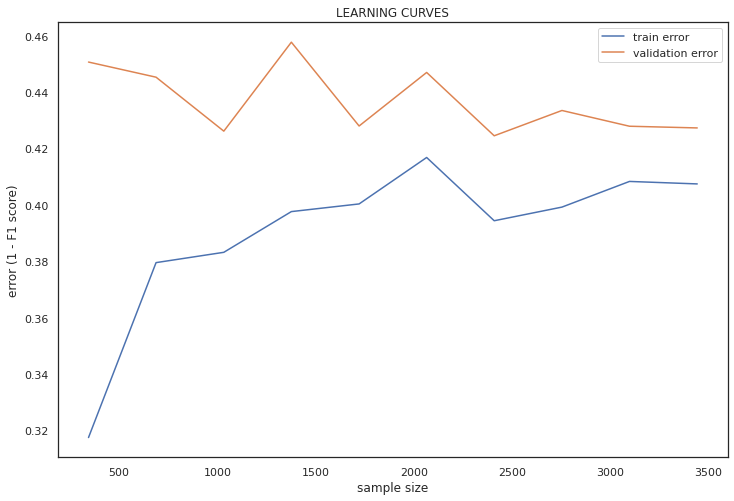

In [21]:
evaluate2(model_1, X1_train, y1_train, X1_test, y1_test)

## Modèle 2 - Logistic Regression avec régularisation

In [23]:
model_2 = make_pipeline(preprocessing, LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=0.5))

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          639           71    710
Actual 1          179          259    438
TOTAL             818          330   1148

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.78      0.90      0.84       710
         1.0       0.78      0.59      0.67       438

    accuracy                           0.78      1148
   macro avg       0.78      0.75      0.76      1148
weighted avg       0.78      0.78      0.77      1148



/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("L

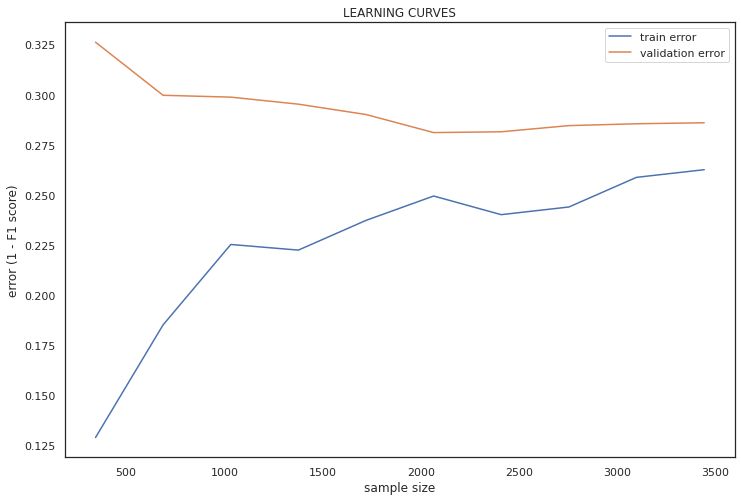

In [24]:
evaluate2(model_2, X1_train, y1_train, X1_test, y1_test)

## Modèle 3 - Random Forest avec toutes les variables + feature importance

### Evaluation du modèle

In [19]:
# Modèle 3 : random forest avec toutes les variables
from sklearn.ensemble import RandomForestClassifier

model_3 = make_pipeline(preprocessing, RandomForestClassifier(random_state=0))

X3_train = trainset.drop(["default"], axis=1)
y3_train = trainset["default"]
X3_test = testset.drop(["default"], axis=1)
y3_test = testset["default"]

__---__ CONFUSION MATRIX __---__
          Predicted 0  Predicted 1  TOTAL
Actual 0          618           92    710
Actual 1          125          313    438
TOTAL             743          405   1148

__---__ CLASSIFICATION REPORT __---__
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       710
         1.0       0.77      0.71      0.74       438

    accuracy                           0.81      1148
   macro avg       0.80      0.79      0.80      1148
weighted avg       0.81      0.81      0.81      1148



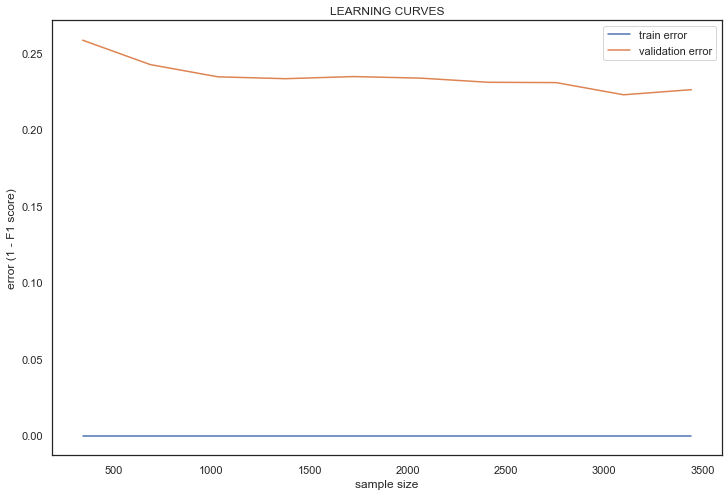

In [20]:
evaluate2(model_3, X3_train, y3_train, X3_test, y3_test)

### Feature Importance

In [27]:
model_3.fit(X3_train, y3_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Catégorie juridique '
                                                   '(Niveau II)']),
                                                 ('pipe_ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['C',
                                                                                               'E',
                                                                                               'P',
                                                                                               'H',
             

In [28]:
# Récupérer les noms des colonnes One Hot !!!
onehot_columns = list(model_3.named_steps['columntransformer'].named_transformers_['pipe_cat'].named_steps['onehotencoder'].get_feature_names(input_features=categ_cols))

In [29]:
total_cols = list(onehot_columns) + list(ordinal_cols) + list(num_cols)

In [31]:
d = {"Columns": total_cols, "Feature Importance":model_3[1].feature_importances_}
fi = pd.DataFrame(d)

In [32]:
fi = fi.sort_values(by="Feature Importance", ascending = False)

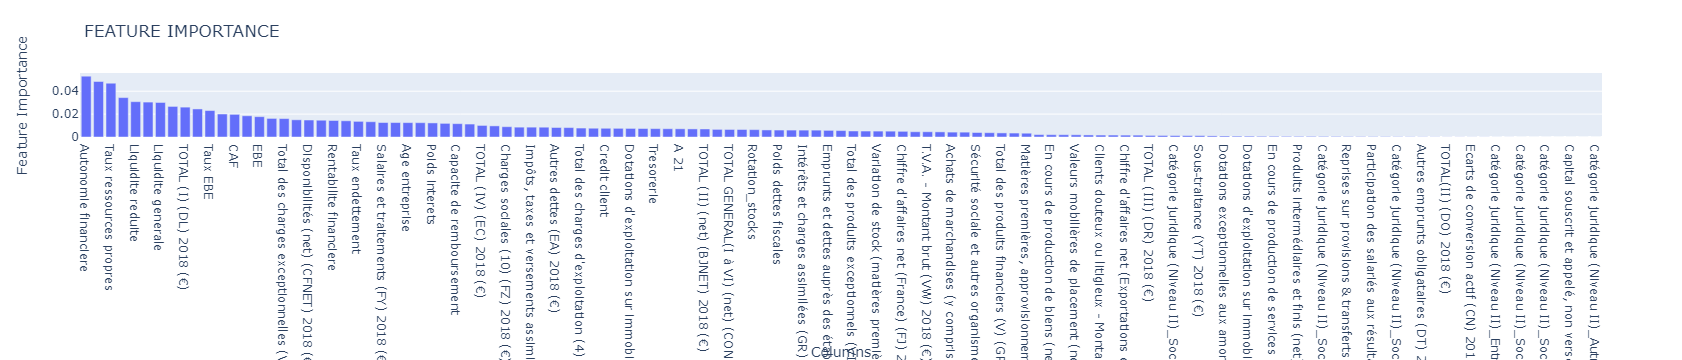

In [33]:
import plotly.express as px
fig = px.bar(fi, x="Columns", y="Feature Importance", title="FEATURE IMPORTANCE")
fig.show()

# PCA

- L'idée : utiliser la PCA pour 2 raisons :
    - 1 => réduire le nombre de variables et résoudre le problème de colinéarité
    - 2 => utiliser derrière un clustering pour essayer de mettre en évidence les 2 groupes (idéalement) 
    
- Marche à suivre :
    - 1) Faire passer la PCA sur mes variables. Ca va me créer un paquet de nouvelles colonnes. Enregistrer tous ces nouveaux features dans un dataframe
    - 2) Supprimer les combinaisons qui ne me servent pas (en-dessous d'un certain seuil de variance expliquée)
    - 3) Faire un KNN avec 2 clusters pour voir si j'y retrouve mes 2 classes
    
Résultats de la PCA :
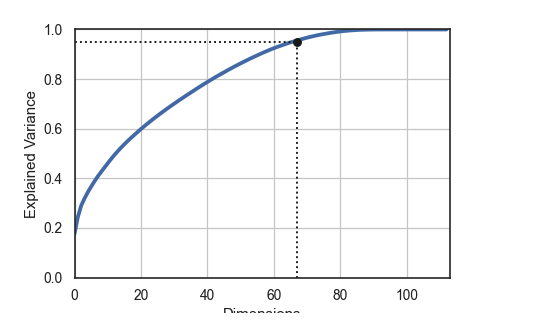


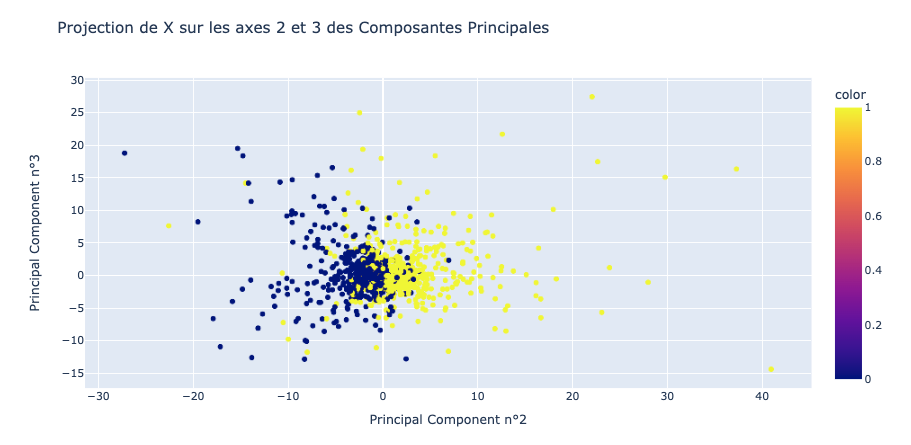

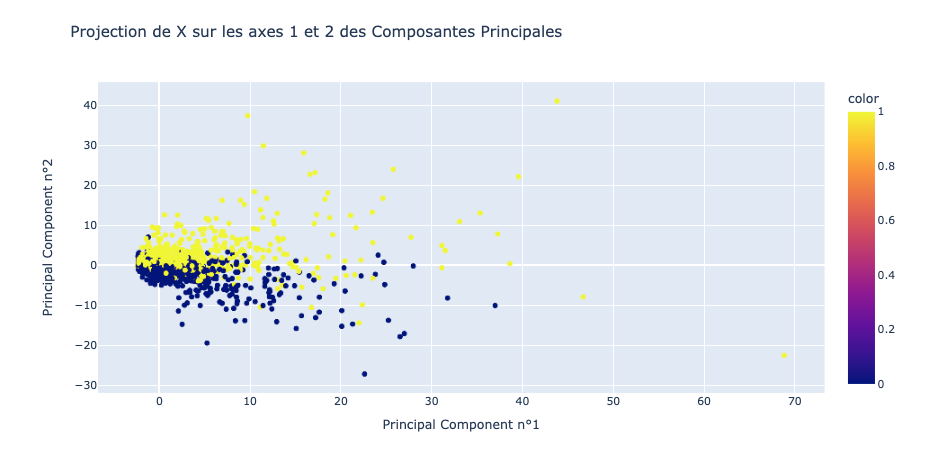

    
## Préprocessing Numérique. 
Objectifs ==> imputer les valeurs manquantes et centrer les données autour de 0

In [34]:
# Définition de la target et des features, sélection seulement des variables numériques
X_pca = df.select_dtypes(include=np.number).drop(["default"], axis=1)
y_pca = df["default"]
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

In [35]:
# StandardScaler sur le train:
from sklearn.preprocessing import StandardScaler


num_scaler = StandardScaler()
X_train_pca_scaled = num_scaler.fit_transform(X_train_pca)
X_train_pca_scaled = pd.DataFrame(X_train_pca_scaled, columns = X_train_pca.columns)
X_train_pca_scaled.shape

(4592, 112)

In [36]:
X_train_pca_scaled.columns

Index(['Capital souscrit non appelé (I) (AA) 2018 (€)', 'TOTAL (II) (net) (BJNET) 2018 (€)', 'Matières premières, approvisionnements (net) (BLNET) 2018 (€)', 'En cours de production de biens (net) (BNNET) 2018 (€)', 'En cours de production de services (net) (BPNET) 2018 (€)', 'Produits intermédiaires et finis (net) (BRNET) 2018 (€)', 'Marchandises (net) (BTNET) 2018 (€)', 'Avances et acomptes versés sur commandes (net) (BVNET) 2018 (€)', 'Clients et comptes rattachés (3) (net) (BXNET) 2018 (€)', 'Autres créances (3) (net) (BZNET) 2018 (€)',
       ...
       'Rentabilite des capitaux propres', 'Autonomie financiere', 'Poids interets', 'Taux EBE', 'Taux VA', 'Taux Rentabilite', 'Poids dettes fiscales', 'Tresorerie', 'Taux augmentation endettement CT', 'Age entreprise'], dtype='object', length=112)

## Identification du nombre de dimensions permettant de contribuer à 95% de la variance des features
- Matrice de covariance des features : vecteurs propres correspondent aux composantes principales, valeurs propres correspondent au % de variance du modèle contenu dans la composante principale.
- **pca.explained_variance_ratio_** renvoie un array de ces valeurs propres. On peut en faire la somme cumulative pour voir l'évolution de la proportion de variance totale expliquée par le modèle au fur et à mesure de l'ajout des dimensions.
- on peut ploter cette somme cumulative de la pca_explained_variance_ratio pour identifier le nombre oprimal de dimensions (au moment où on a une cassure sur la courbe)

In [37]:
from sklearn.decomposition import PCA
pca = PCA() # on instancie sans fixer le n_components
pca.fit(X_train_pca_scaled)
# % de variance du modèle contenu dans chaque composante principale
pca.explained_variance_ratio_

array([1.75537100e-01, 6.82347628e-02, 4.49282604e-02, 2.90763641e-02,
       2.50246768e-02, 2.18378379e-02, 2.12342696e-02, 1.95555624e-02,
       1.79476524e-02, 1.78010946e-02, 1.72680306e-02, 1.67989959e-02,
       1.59605558e-02, 1.54733418e-02, 1.53219708e-02, 1.39361764e-02,
       1.32780242e-02, 1.29061071e-02, 1.24873027e-02, 1.21428503e-02,
       1.17158367e-02, 1.11907063e-02, 1.11283883e-02, 1.11030549e-02,
       1.05755009e-02, 1.04059200e-02, 1.01412066e-02, 9.83000010e-03,
       9.72840888e-03, 9.53852310e-03, 9.36182248e-03, 9.27751450e-03,
       9.10532246e-03, 9.04660052e-03, 8.98307452e-03, 8.91976060e-03,
       8.83327338e-03, 8.72835684e-03, 8.55550279e-03, 8.48904398e-03,
       8.33863947e-03, 8.12165641e-03, 8.02447975e-03, 7.84298233e-03,
       7.56318598e-03, 7.46955446e-03, 7.36996450e-03, 7.27578250e-03,
       7.14777640e-03, 6.99810186e-03, 6.96193529e-03, 6.67494164e-03,
       6.63776478e-03, 6.44498904e-03, 6.30551308e-03, 6.20561185e-03,
      

In [38]:
pca.explained_variance_ratio_.shape

(112,)

In [39]:
print("la première composante principale explique:", int(round(pca.explained_variance_ratio_[0],2)*100),"% de la variance")
print("la seconde composante principale explique:", int(round(pca.explained_variance_ratio_[1],2)*100),"% de la variance")
print("la troisième composante principale explique:", int(round(pca.explained_variance_ratio_[2],2)*100),"% de la variance")

la première composante principale explique: 18 % de la variance
la seconde composante principale explique: 7 % de la variance
la troisième composante principale explique: 4 % de la variance


In [40]:
# On fait la somme cumulée de la variance expliquée
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum

array([0.1755371 , 0.24377186, 0.28870012, 0.31777649, 0.34280116,
       0.364639  , 0.38587327, 0.40542883, 0.42337649, 0.44117758,
       0.45844561, 0.47524461, 0.49120516, 0.50667851, 0.52200048,
       0.53593665, 0.54921468, 0.56212078, 0.57460809, 0.58675094,
       0.59846677, 0.60965748, 0.62078587, 0.63188892, 0.64246442,
       0.65287034, 0.66301155, 0.67284155, 0.68256996, 0.69210848,
       0.7014703 , 0.71074782, 0.71985314, 0.72889974, 0.73788282,
       0.74680258, 0.75563585, 0.76436421, 0.77291971, 0.78140875,
       0.78974739, 0.79786905, 0.80589353, 0.81373651, 0.8212997 ,
       0.82876925, 0.83613922, 0.843415  , 0.85056278, 0.85756088,
       0.86452281, 0.87119776, 0.87783552, 0.88428051, 0.89058602,
       0.89679163, 0.90294883, 0.90887683, 0.91460113, 0.92010972,
       0.92550053, 0.93046769, 0.93537968, 0.94006133, 0.94460565,
       0.94891146, 0.95316191, 0.95709548, 0.96096034, 0.96471108,
       0.96826643, 0.97163169, 0.97488754, 0.97774306, 0.98035

In [41]:
d = np.argmax(cumsum >= 0.95) + 1
d # nombre de dimensions pour lesquelles la variance est au total de plus de 95%

67

**Résultats** 
- On peut réduire de 40% le nombre de features tout en conservant 95% de la variance (on passe de 113 à 67)
- Si on accepte d'avoir 80% de la variance, on passe à 43 features

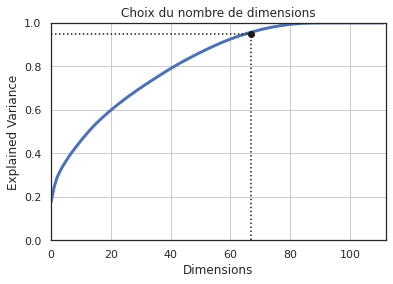

In [43]:
# représentation graphique de CUMSUM :
# code du livre d'A Géron
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, X_train_pca_scaled.shape[1], 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.title("Choix du nombre de dimensions")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
#plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             #arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

## Projection de X sur 67 dimensions => nouveau DF
C'est sur ce dataframe qu'il va falloir tester un KNN

In [44]:
# application 
pca = PCA(n_components = d)
X_train_reduced = pca.fit_transform(X_train_pca_scaled)
X_train_reduced.shape

(4592, 67)

In [45]:
# Transformation du X_test (scaler et PCA)
X_test_pca_scaled = num_scaler.transform(X_test_pca)
X_test_reduced = pca.transform(X_test_pca_scaled)

In [46]:
X_test_reduced.shape

(1148, 67)

## Représentation graphique de X sur les deux premiers axes
On colore selon le y_train qui est de 0 ou de 1

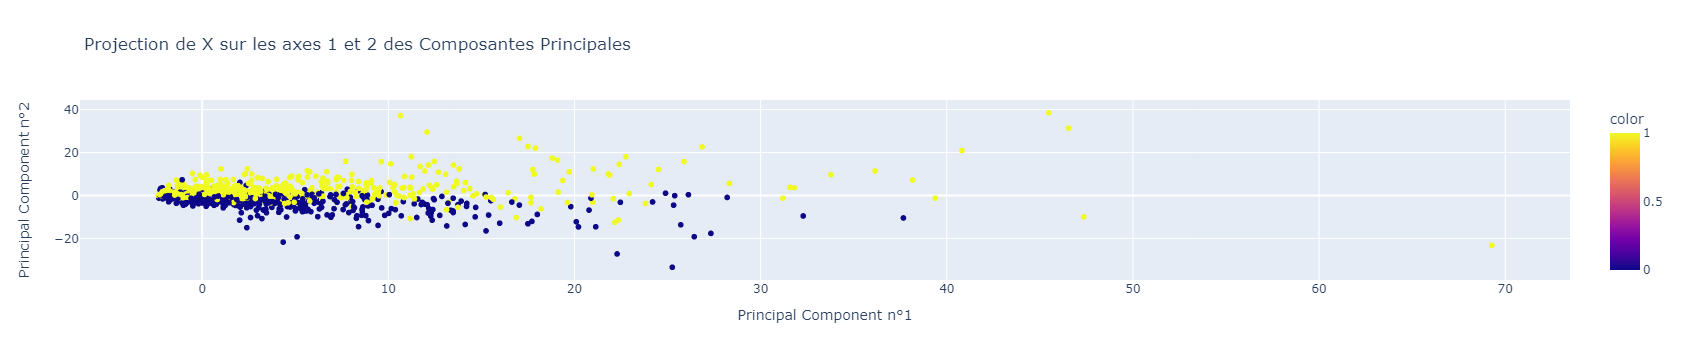

In [49]:
import plotly.express as px
from sklearn.decomposition import PCA


X = X_train_pca_scaled

pca = PCA(n_components=d)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=y_train_pca, 
                 labels = {
    "0":"Principal Component n°1",
    "1":"Principal Component n°2"
                        },
                title="Projection de X sur les axes 1 et 2 des Composantes Principales") 
fig.show()


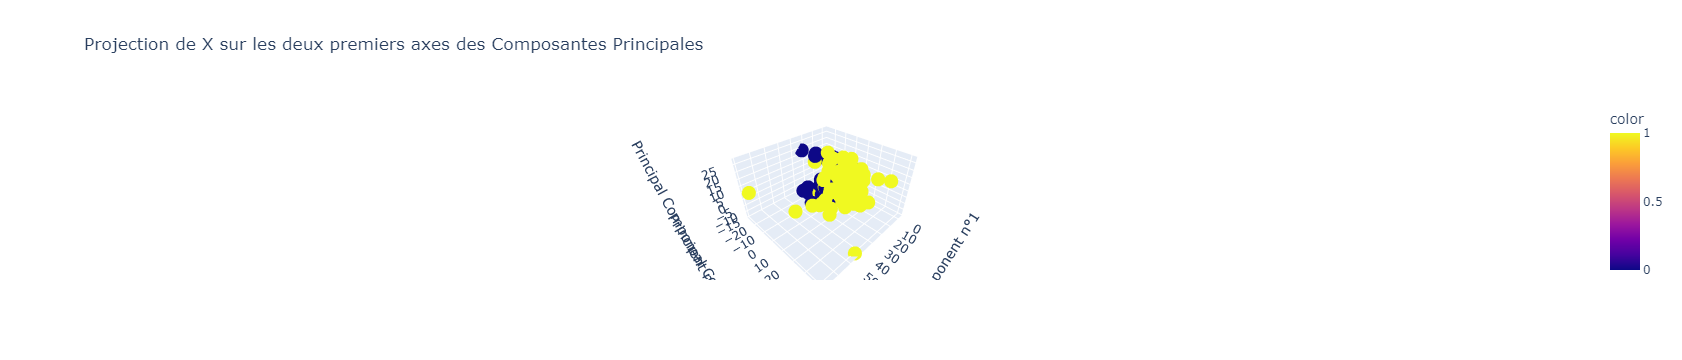

In [99]:
import plotly.express as px
from sklearn.decomposition import PCA


X = X_train_pca_scaled

pca = PCA(n_components=d)
components = pca.fit_transform(X)

fig = px.scatter_3d(components, x=0, y=1, z=2, color=y_train_pca, 
                 labels = {
    "0":"Principal Component n°1",
    "1":"Principal Component n°2",
    "2":"Principal Component n°3"
                        },
                title="Projection de X sur les deux premiers axes des Composantes Principales") 
fig.show()

## Clustering sur la PCA

In [105]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_reduced)

In [106]:
y_pred = kmeans.predict(X_train_reduced)

In [107]:
y_train_pca.sum()

1485.0

In [108]:
y_pred.shape

(3845,)

In [109]:
y_pred.sum()

229

In [111]:
for i in range(y_train_pca.shape[0]):
    print(y_pred[i], '-------', np.array(y_train_pca, dtype='int32')[i])
    #print(np.array(y_train, dtype='int32')[i])

0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 1
0 ------- 1
0 ------- 0
0 ------- 1
0 ------- 0
0 ------- 1
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 1
0 ------- 0
0 ------- 0
0 ------- 1
0 ------- 1
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 1
0 ------- 1
1 ------- 0
0 ------- 0
0 ------- 0
0 ------- 1
0 ------- 0
0 ------- 1
0 ------- 0
0 ------- 1
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 1
0 ------- 0
0 ------- 1
0 ------- 0
0 ------- 1
0 ------- 1
0 ------- 1
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 0
1 ------- 1
0 ------- 1
0 ------- 1
0 ------- 1
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 1
0 ------- 1
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 1
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 1
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 1
0 ------- 0
0 ------- 1
0 ------- 1
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 1
0 ------- 1
0 ------- 0
0 ------- 0
0 ------- 1
1 ------- 0
0 ------- 1
0 --

In [112]:
kmeans2 = KMeans(n_clusters=2, random_state=0, algorithm='elkan').fit(X_train_reduced)

In [113]:
y_pred2 = kmeans2.predict(X_train_reduced)

In [114]:
y_pred2.sum()

229